In [1]:
%%time
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from dataclasses import dataclass
from pathlib import Path

# 必要なライブラリのインポート
import pandas as pd
from dotenv import load_dotenv


@dataclass
class Config:
    project_dir: Path = Path("../../")
    model_dir: Path = project_dir / "models"
    outputs_dir: Path = project_dir / "outputs"
    results_dir: Path = project_dir / "results"
    results_agg_dir: Path = results_dir / "agg"
    results_figs_dir: Path = results_dir / "figs"
    data_dir: Path = project_dir / "data"
    raw_dir: Path = data_dir / "raw"
    interim_dir: Path = data_dir / "interim"
    processed_dir: Path = data_dir / "processed"


config = Config()
sys.path.append(str(config.project_dir.resolve()))
load_dotenv()

CPU times: user 858 ms, sys: 258 ms, total: 1.12 s
Wall time: 1.66 s


True

In [3]:
df_order_info_details = pd.read_csv(config.processed_dir / "order_info_details.csv")
df_reviews = pd.read_csv(
    config.interim_dir
    / "olist_order_reviews_translated_label_review_categories_merged.csv",
)
df_reviews_last = df_reviews.groupby("order_id").last().reset_index()
df_order_info_details_reviews_merged = pd.merge(
    df_order_info_details, df_reviews_last, on="order_id", how="left"
)
assert df_order_info_details_reviews_merged.shape[0] == df_order_info_details.shape[0]
for col in [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "shipping_limit_date",
]:
    df_order_info_details_reviews_merged[col] = pd.to_datetime(
        df_order_info_details_reviews_merged[col],
        format="mixed",
    )
df_review_no_null = df_order_info_details_reviews_merged.dropna(
    subset=["review_comment_message_en"]
)
print(f"df_review_no_null.shape: {df_review_no_null.shape}")

df_target = (
    df_review_no_null.query(
        "review_categories_str_modified in ['Delivery_Issue','Delivery_Praise'] "
    )
    .query("customer_state in ['SP','RJ']")
    .dropna(subset=["order_delivered_customer_span_hours_from_carrier"])
)
df_target["is_same_state"] = (
    df_target["customer_state"] == df_target["seller_state"]
).astype(int)
df_target["is_same_city"] = (
    df_target["customer_city"] == df_target["seller_city"]
).astype(int)
df_target["freight_ratio"] = (
    df_target["sum_freight"] / df_target["sum_price_freight_by_order"]
)

y, x = (
    df_target["order_delivered_customer_span_hours_from_carrier"],
    df_target[
        [
            "order_purchase_month",
            "customer_city",
            "customer_state",
            "sum_price",
            "sum_freight",
            # "freight_ratio",
            "sum_price_freight_by_order",
            "product_count",
            "seller_count",
            "product_photos_qty",
            "sum_product_weight_g",
            "sum_product_volume_cm3",
            "product_length_cm",
            "product_height_cm",
            "product_width_cm",
            "seller_city_count",
            "seller_state_count",
            "product_category_name_english",
            "seller_city",
            "seller_state",
            "distance_between_customer_and_seller",
            "is_same_state",
            "is_same_city",
            "total_payment_value",
            "payment_type_count",
            "most_common_payment_type",
            "highest_value_payment_type",
            "highest_payment_value",
        ]
    ],
)
categorical_features = [
    "order_purchase_month",
    "customer_city",
    "customer_state",
    "product_category_name_english",
    "seller_city",
    "seller_state",
    "most_common_payment_type",
    "highest_value_payment_type",
]
param_dist = {
    "num_leaves": [31, 50, 100, 200],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200, 500, 1000],
    "feature_fraction": [0.7, 0.8, 0.9, 1.0],
    "min_child_samples": [10, 20, 30, 50],
    "max_depth": [-1, 5, 10, 20],
    "reg_alpha": [0, 0.1, 0.5, 1.0],
    "reg_lambda": [0, 0.1, 0.5, 1.0],
    "bagging_fraction": [0.8, 0.9, 1.0],
    "bagging_freq": [0, 5, 10],
}

df_review_no_null.shape: (40818, 85)


In [9]:
from src.trainer.train_lgbm import LGBMTrainer

lgbm_trainer = LGBMTrainer(
    x=x, y=y, categorical_features=categorical_features, params=param_dist
)
lgbm_trainer.train(best_model_output_path=config.model_dir / "best_lgbm_model.pickle")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


<string>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[CV] END bagging_fraction=0.8, bagging_freq=10, feature_fraction=0.8, learning_rate=0.1, max_depth=20, min_child_samples=10, n_estimators=200, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5; total time=  21.9s
[CV] END bagging_fraction=0.8, bagging_freq=10, feature_fraction=0.8, learning_rate=0.1, max_depth=20, min_child_samples=10, n_estimators=200, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5; total time=  22.1s
[CV] END bagging_fraction=0.8, bagging_freq=10, feature_fraction=0.8, learning_rate=0.1, max_depth=20, min_child_samples=10, n_estimators=200, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5; total time=  22.2s
[CV] END bagging_fraction=0.8, bagging_freq=10, feature_fraction=0.8, learning_rate=0.1, max_depth=20, min_child_samples=10, n_estimators=200, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5; total time=  22.2s
[CV] END bagging_fraction=0.8, bagging_freq=10, feature_fraction=0.8, learning_rate=0.1, max_depth=20, min_child_samples=10, n_estimators=200, num_leaves=100, reg_a

2025-03-31 22:31:02,435 - src.trainer.train_lgbm - INFO - Best params: {'reg_lambda': 1.0, 'reg_alpha': 1.0, 'num_leaves': 200, 'n_estimators': 1000, 'min_child_samples': 50, 'max_depth': 5, 'learning_rate': 0.01, 'feature_fraction': 0.7, 'bagging_freq': 0, 'bagging_fraction': 0.9}
2025-03-31 22:31:02,437 - src.trainer.train_lgbm - INFO - Best cross-validation RMSE: 224.3951


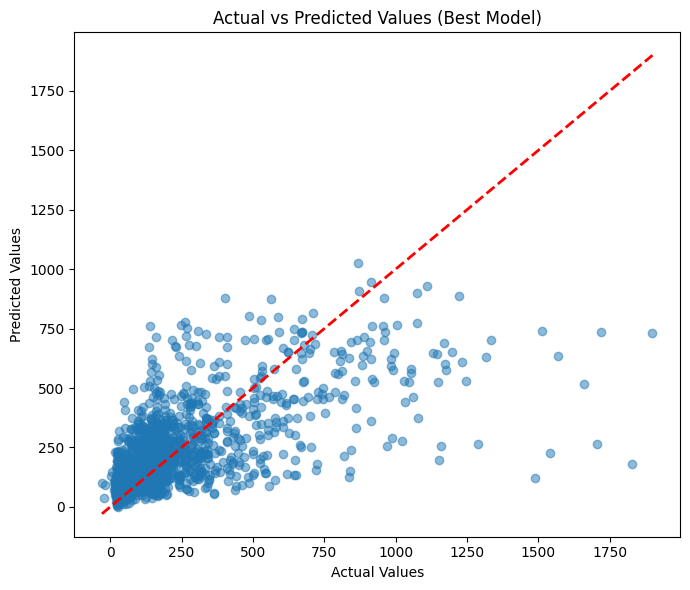

In [10]:
lgbm_trainer.plot_actual_vs_predicted()


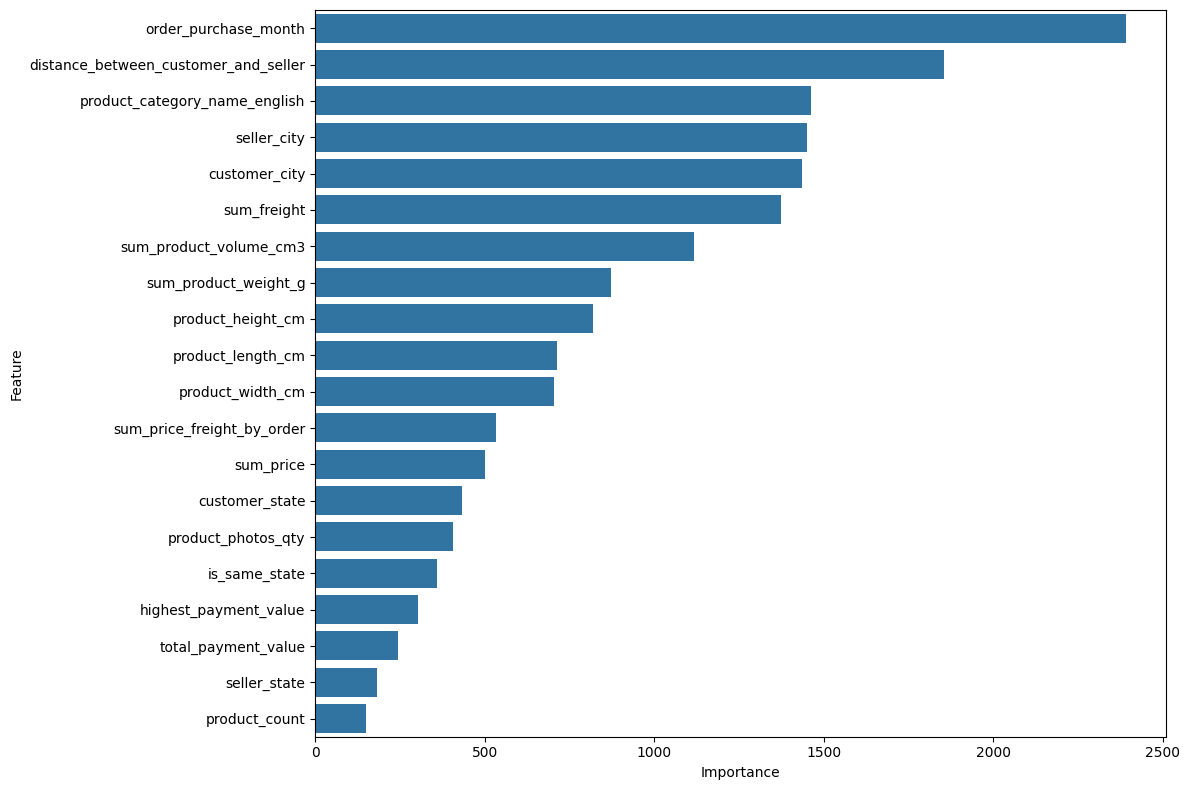

In [19]:
lgbm_trainer.plot_feature_importance()


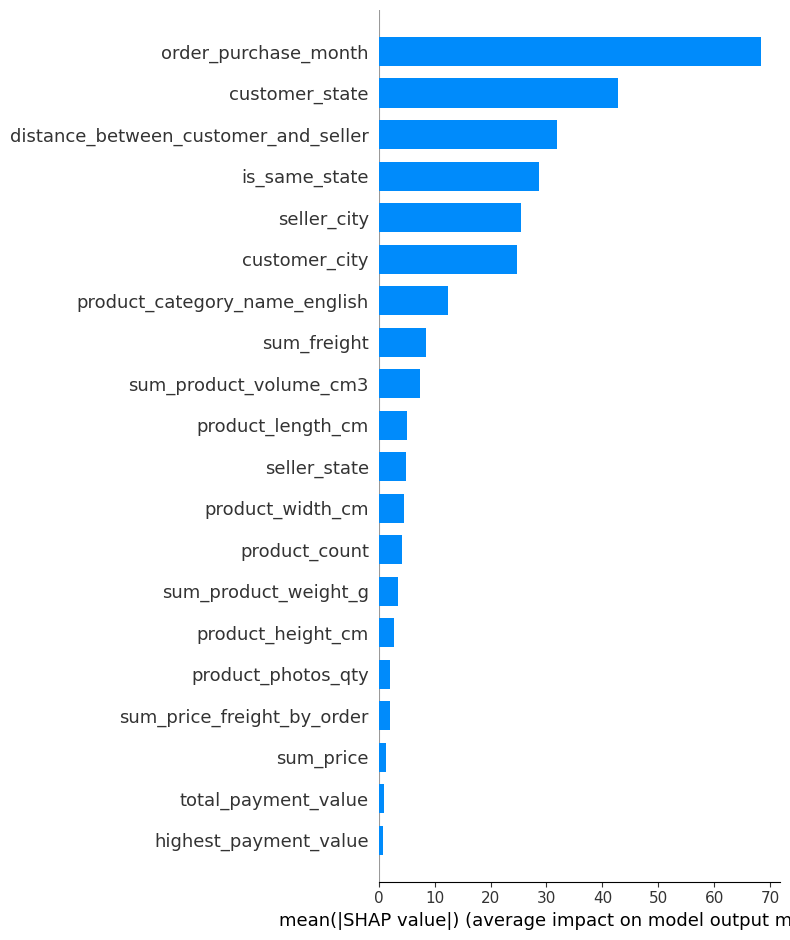

In [12]:
lgbm_trainer.plot_shap_values()